In [1]:
# https://pypi.org/project/PuLP/
# https://coin-or.github.io/pulp/guides/index.html

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
import json
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sqlite3 import connect
from sklearn.preprocessing import RobustScaler

In [5]:
pd.options.display.float_format = "{:.2f}".format

In [6]:
# Get the absolute path of the file within the INPUTS directory
file_path = os.path.join(os.getcwd(), 'INPUTS', 'case_study_data.csv')

# Print the file path
print(file_path)

C:\Users\KonuTech\PycharmProjects\supply-chain-case-study\INPUTS\case_study_data.csv


In [7]:
# Get the absolute path of the config within the CONFIGS directory
config_path = os.path.join(os.getcwd(), 'CONFIGS', 'config.json')

# Print the fileconfig_pathpath
print(config_path)

C:\Users\KonuTech\PycharmProjects\supply-chain-case-study\CONFIGS\config.json


In [8]:
with open(config_path, encoding='utf-8') as f:
    CONFIG = json.load(f)

In [9]:
INDEX_COL = CONFIG["INPUTS"]["INDEX_COLUMNS"]
SEP = CONFIG["INPUTS"]["SEPARATOR"]
DECIMAL = CONFIG["INPUTS"]["DECIMAL"]
ENCODING = CONFIG["INPUTS"]["ENCODING"]
DATE_COLUMNS = CONFIG["INPUTS"]["DATE_COLUMNS"]
FLOAT_PRECISION = CONFIG["INPUTS"]["FLOAT_PRECISION"]
DTYPE = CONFIG["INPUTS"]["DTYPE"]
COLUMNS_WITH_NAN_VALUES = CONFIG["INPUTS"]["COLUMNS_WITH_NAN_VALUES"]

In [10]:
df = pd.read_csv(
    file_path,
#     index_col=INDEX_COL,
    sep=SEP,
    encoding=ENCODING,
    engine="c",
    low_memory=False,
#     parse_dates=DATE_COLUMNS,
    dtype=DTYPE
)

In [11]:
print(df.index.duplicated())

[False False False ... False False False]


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9993 entries, 0 to 9992
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order ID      9993 non-null   object 
 1   Order Date    9993 non-null   object 
 2   Ship Mode     9993 non-null   object 
 3   Region        9993 non-null   object 
 4   Product ID    9993 non-null   object 
 5   Category      9993 non-null   object 
 6   Sub-Category  9993 non-null   object 
 7   Product Name  9993 non-null   object 
 8   Sales         9993 non-null   float64
 9   Quantity      9993 non-null   int64  
 10  Discount      9993 non-null   float64
 11  Profit        8000 non-null   float64
dtypes: float64(3), int64(1), object(8)
memory usage: 937.0+ KB


# PREPROCESSING

In [13]:
# df.index = pd.to_datetime(df["Order Date"])

In [14]:
# Use regex to separate the string parts of the Order ID column into separate fields
df[['Order ID prefix', 'Order ID year', 'Order ID number']] = df['Order ID'].str.extract(r'(\w+)-(\d+)-(\d+)')

# Use regex to separate the string parts of the Order Date column into separate fields
df[['Order Year', 'Order Month', 'Order Day']] = pd.to_datetime(df['Order Date']).dt.strftime('%Y-%m-%d').str.extract(r'(\d{4})-(\d{2})-(\d{2})')

In [15]:
# Normalize Profit column as new column
df['Normalized Profit'] = (df['Profit'] - df['Profit'].mean()) / df['Profit'].std()

In [16]:
# Normalize Sales column as new column
df['Normalized Sales'] = (df['Sales'] - df['Sales'].mean()) / df['Sales'].std()

In [17]:
# Standardize Profit column as new column
mean_profit = df['Profit'].mean()
std_profit = df['Profit'].std()
df['Standardized Profit'] = (df['Profit'] - mean_profit) / std_profit

In [18]:
# Standardize Sales column as new column
mean_sales = df['Sales'].mean()
std_sales = df['Sales'].std()
df['Standardized Sales'] = (df['Sales'] - mean_sales) / std_sales

In [19]:
df['Winsorized Sales'] = stats.mstats.winsorize(df['Sales'], limits=[0.05, 0.05])

In [20]:
df['Winsorized Profit'] = stats.mstats.winsorize(df['Profit'], limits=[0.05, 0.05])

In [21]:
# Use RobustScaler to scale Sales using IQR method as new column
scaler = RobustScaler()
df['Scaled Sales'] = scaler.fit_transform(df[['Sales']])
df['Scaled Profit'] = scaler.fit_transform(df[['Profit']])

In [22]:
df_sample = df.sample(n=3000)

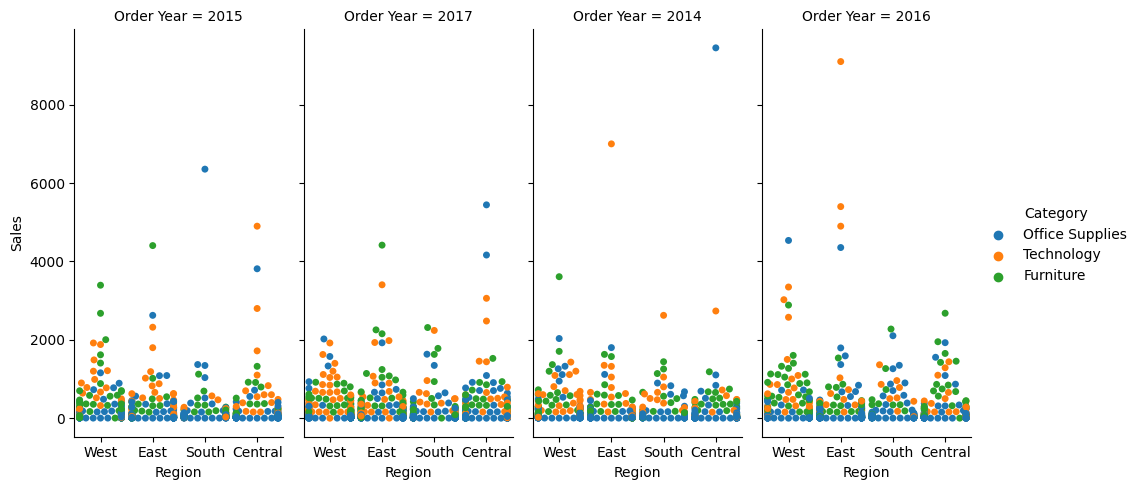

In [23]:
sns.catplot(
    data=df_sample, kind="swarm",
    x="Region", y="Sales", hue="Category", col="Order Year",
    aspect=.5
)

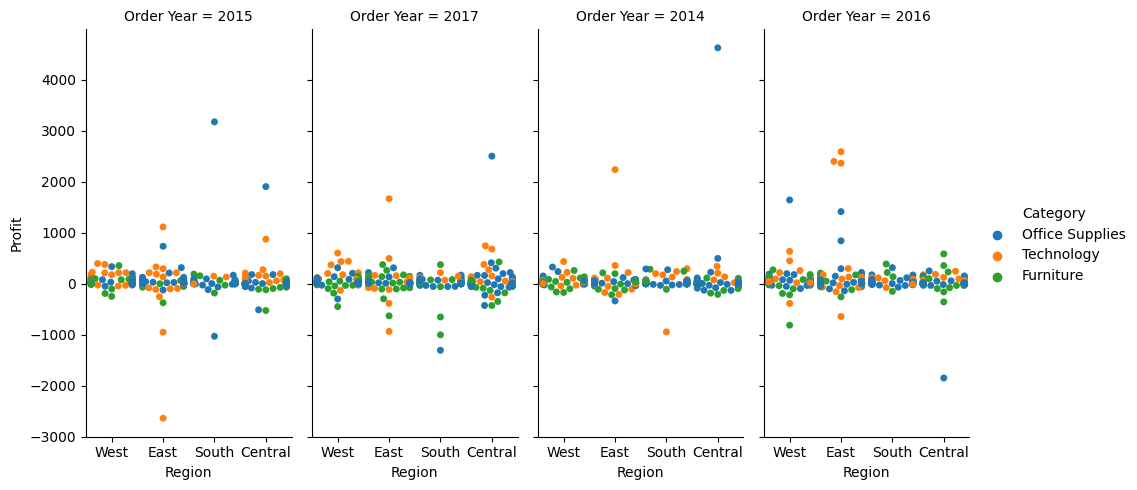

In [24]:
sns.catplot(
    data=df_sample, kind="swarm",
    x="Region", y="Profit", hue="Category", col="Order Year",
    aspect=.5
)

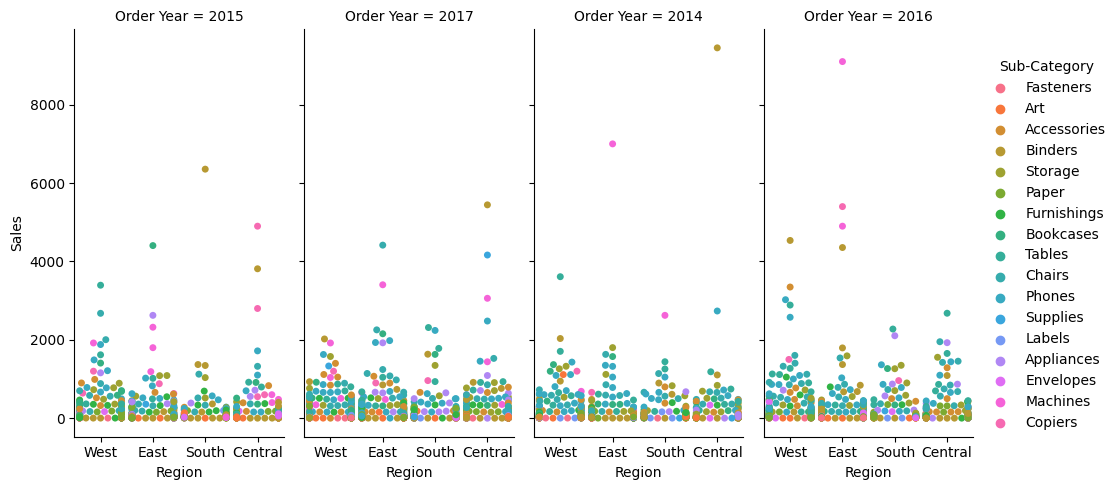

In [25]:
sns.catplot(
    data=df_sample, kind="swarm",
    x="Region", y="Sales", hue="Sub-Category", col="Order Year",
    aspect=.5
)

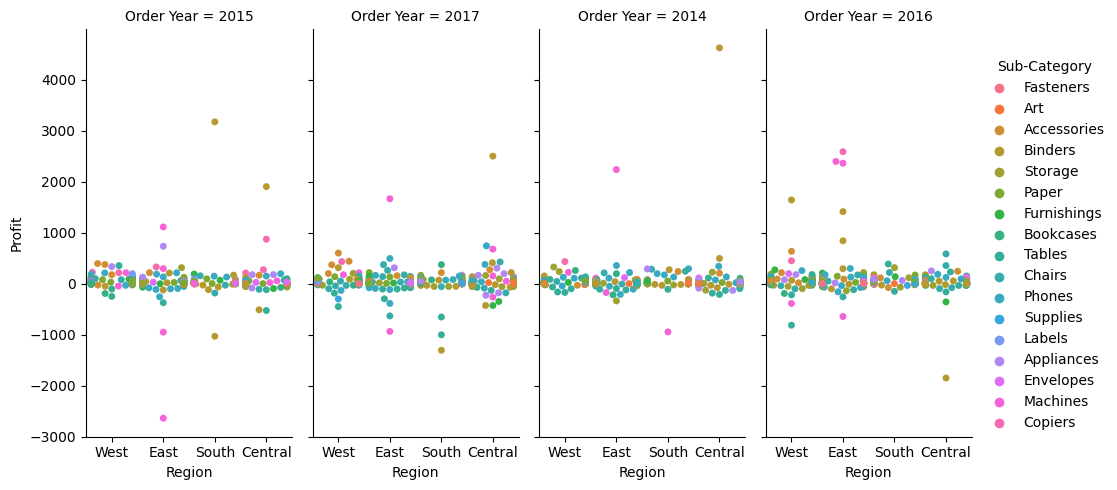

In [26]:
sns.catplot(
    data=df_sample, kind="swarm",
    x="Region", y="Profit", hue="Sub-Category", col="Order Year",
    aspect=.5
)

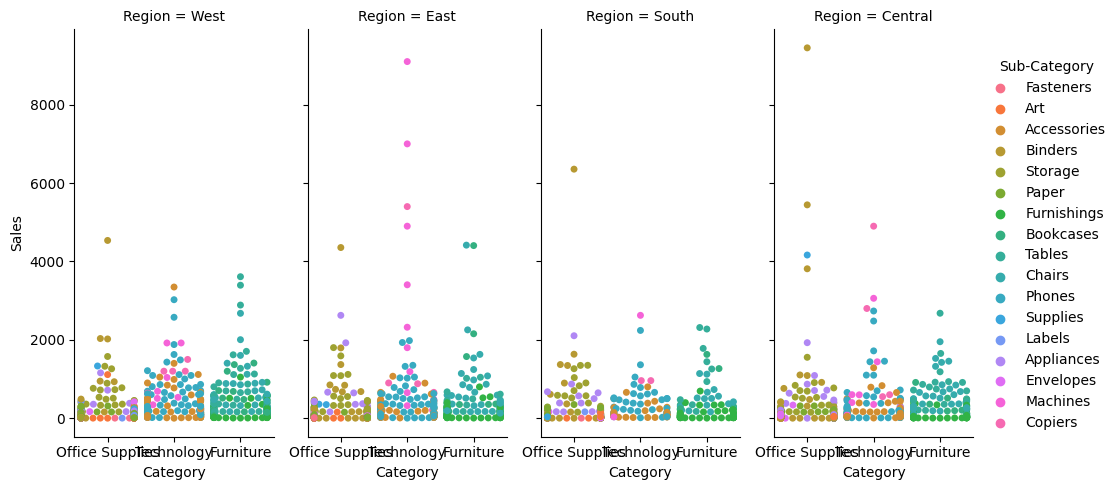

In [27]:
sns.catplot(
    data=df_sample, kind="swarm",
    x="Category", y="Sales", hue="Sub-Category", col="Region",
    aspect=.5
)

In [ ]:
for i, v in enumerate(df["Order Year"].unique()):
    print(v)
    sns.catplot(
        data=df_sample[df_sample["Order Year"] == v], kind="swarm",
        x="Category", y="Sales", hue="Sub-Category", col="Region",
        aspect=.5
    )

2015


In [ ]:
sns.catplot(
    data=df_sample, kind="swarm",
    x="Category", y="Profit", hue="Sub-Category", col="Region",
    aspect=.5
)

In [ ]:
for i, v in enumerate(df["Order Year"].unique()):
    print(v)
    sns.catplot(
        data=df_sample[df_sample["Order Year"] == v], kind="swarm",
        x="Category", y="Profit", hue="Sub-Category", col="Region",
        aspect=.5
    )

In [ ]:
for i, v in enumerate(df["Order Year"].unique()):
    print(v)
    g = sns.JointGrid(data=df_sample[df_sample["Order Year"] == v], x="Normalized Sales", y="Normalized Profit", hue="Category")
    g.plot(sns.scatterplot, sns.histplot)

In [ ]:
for i, v in enumerate(df["Order Year"].unique()):
    print(v)
    g = sns.JointGrid(data=df_sample[df_sample["Order Year"] == v], x="Normalized Sales", y="Normalized Profit")
    g.plot(sns.regplot, sns.boxplot)

In [ ]:
for i, v in enumerate(df["Order Year"].unique()):
    print(v)
    g = sns.JointGrid(data=df_sample[df_sample["Order Year"] == v], x="Standardized Sales", y="Standardized Profit", hue="Category")
    g.plot(sns.scatterplot, sns.histplot)

In [ ]:
for i, v in enumerate(df["Order Year"].unique()):
    print(v)
    g = sns.JointGrid(data=df_sample[df_sample["Order Year"] == v], x="Standardized Sales", y="Standardized Profit")
    g.plot(sns.regplot, sns.boxplot)

In [ ]:
for i, v in enumerate(df["Order Year"].unique()):
    print(v)
    g = sns.JointGrid(data=df_sample[df_sample["Order Year"] == v], x="Winsorized Sales", y="Winsorized Profit", hue="Category")
    g.plot(sns.scatterplot, sns.histplot)

In [ ]:
for i, v in enumerate(df["Order Year"].unique()):
    print(v)
    g = sns.JointGrid(data=df_sample[df_sample["Order Year"] == v], x="Winsorized Sales", y="Winsorized Profit")
    g.plot(sns.regplot, sns.boxplot)

In [ ]:
for i, v in enumerate(df["Order Year"].unique()):
    print(v)
    g = sns.JointGrid(data=df_sample[df_sample["Order Year"] == v], x="Scaled Sales", y="Scaled Profit", hue="Category")
    g.plot(sns.scatterplot, sns.histplot)

In [ ]:
for i, v in enumerate(df["Order Year"].unique()):
    print(v)
    g = sns.JointGrid(data=df_sample[df_sample["Order Year"] == v], x="Scaled Sales", y="Scaled Profit")
    g.plot(sns.regplot, sns.boxplot)

In [ ]:
sns.lineplot(
    data=df_sample, x="Order Date", y="Sales", hue="Region", style="Category",
)

In [ ]:
df_sample.index = pd.to_datetime(df_sample["Order Date"])

In [ ]:
df_sample.info()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the time series data
# data = pd.read_csv("data.csv", index_col=0, parse_dates=True)

# Resample the data to monthly intervals and calculate the mean
monthly_data = df_sample.resample('M').mean()

# Create a line chart of the resampled data
plt.plot(monthly_data.index, monthly_data['Sales'])
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Monthly Time Series")

# Show the plot
plt.show()
